<a href="https://colab.research.google.com/github/Arju-Jawla/Mean-Sea-Level-Anomalies/blob/main/MSLA_04_STL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. INSTALLING REQUIRED LIBRARIES

In [ ]:
!pip install netCDF4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 30.8 MB/s eta 0:00:00


In [ ]:
!pip install ctime

  Preparing metadata (setup.py) ... done
  Created wheel for ctime: filename=ctime-1.0.0-py3-none-any.whl size=2673 sha256=2c99baa33f1c6702b4abd411345398e7dd776769990a7718fa3369cc2a46b871
  Stored in directory: /root/.cache/pip/wheels/9e/e0/b5/931e02f22d8e9bdf979e6451e9d246a253e049638a9af7cc67
Successfully built ctime


In [ ]:
import numpy as np                           #numerical python library
import pandas as pd                          #data manipulation and analysis library

%matplotlib inline
import matplotlib.pyplot as plt              #plotting library

from netCDF4 import Dataset                  #reading netcdf files

import cftime                                #for time conversion
import datetime                              #for date manipulation
from datetime import datetime

In [ ]:
from statsmodels.tsa.seasonal import STL
import seaborn as sns

## 2. loading data and assign variables

In [ ]:
#load nc file from google drive
ncfile = '/content/drive/MyDrive/Project Learnings/Data/dt_global_satellite_sla_199302_202305.nc'

In [ ]:
# Open the netCDF file specified by 'ncfile' in read-only mode ('r')
# and assign it to the file handle 'fh'
fh = Dataset(ncfile, mode = 'r')

In [ ]:
#extracting the variable
sla = fh.variables['sla'][:]
lon  = fh.variables['longitude'][:]
lat  = fh.variables['latitude'][:]
time_var = fh.variables['time']

In [ ]:
dates = cftime.num2date(time_var[:], units=time_var.units)
dates_converted = [datetime(d.year, d.month, d.day) for d in dates]

## 3. Extracting data for Ports

In [ ]:
# Define coordinates for each port (approximate)
# Each subregion will cover 1x1 degree around the port
ports = {
    "Vishakhapatnam": {"lat": 17.7, "lon": 83.3},
    "Kandla": {"lat": 23.0, "lon": 70.2},
    "Mumbai": {"lat": 19.0, "lon": 72.8},
    "Paradip": {"lat": 20.3, "lon": 86.6},
    "Cochin": {"lat": 9.9, "lon": 76.3}
}

In [ ]:
# Function to get index range for a specified grid point with 1x1 degree tolerance
def get_grid_indices(lat, lon, lat_values, lon_values, tolerance=0.5):
    lat_indices = np.where((lat_values >= lat - tolerance) & (lat_values <= lat + tolerance))[0]
    lon_indices = np.where((lon_values >= lon - tolerance) & (lon_values <= lon + tolerance))[0]
    return lat_indices, lon_indices

In [ ]:
# Loop through each port and extract data
subregion_data = {}                                          #creates empty dict
for port, coords in ports.items():
    lat_idx, lon_idx = get_grid_indices(coords["lat"], coords["lon"], lat, lon)

    # Extract temperature data for the subregion
    subregion_sla = sla[:, lat_idx[0]:lat_idx[-1] + 1, lon_idx[0]:lon_idx[-1] + 1]
    subregion_sla_mean = np.mean(subregion_sla, axis=(1, 2))  # Mean over spatial dimensions (lat, lon)

    # Store in dictionary
    subregion_data[port] = subregion_sla_mean

## Preprocessing data for further Analysis

In [ ]:
# Create a DataFrame from the subregion data
data = pd.DataFrame(subregion_data)
data['Date'] = dates_converted
data.set_index('Date', inplace=True)

In [ ]:
# Create a time variable (e.g., ordinal date)
data['time'] = np.arange(len(data))

## 5. Seasonal-Trend decomposition using LOESS

In [ ]:
# Define a dictionary to store decomposition results
seasonal_decomposition_results = {}

In [ ]:
# Perform STL decomposition for each port
for port in ['Vishakhapatnam', 'Kandla', 'Mumbai', 'Paradip', 'Cochin']:
    # Decompose with a seasonal period of 13 (monthly data with yearly seasonality)
    stl = STL(data[port], period=13)  # Specify the period directly
    result = stl.fit()

    # Store the decomposition results
    seasonal_decomposition_results[port] = {
        'trend': result.trend,
        'seasonal': result.seasonal,
        'residual': result.resid
    }

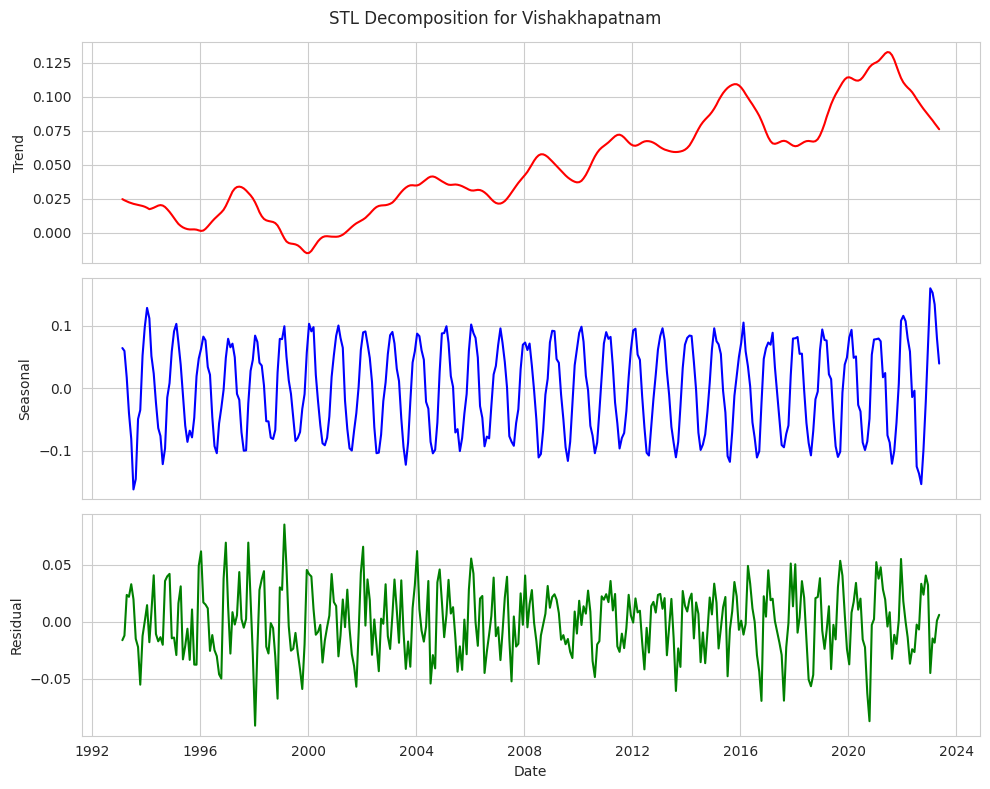

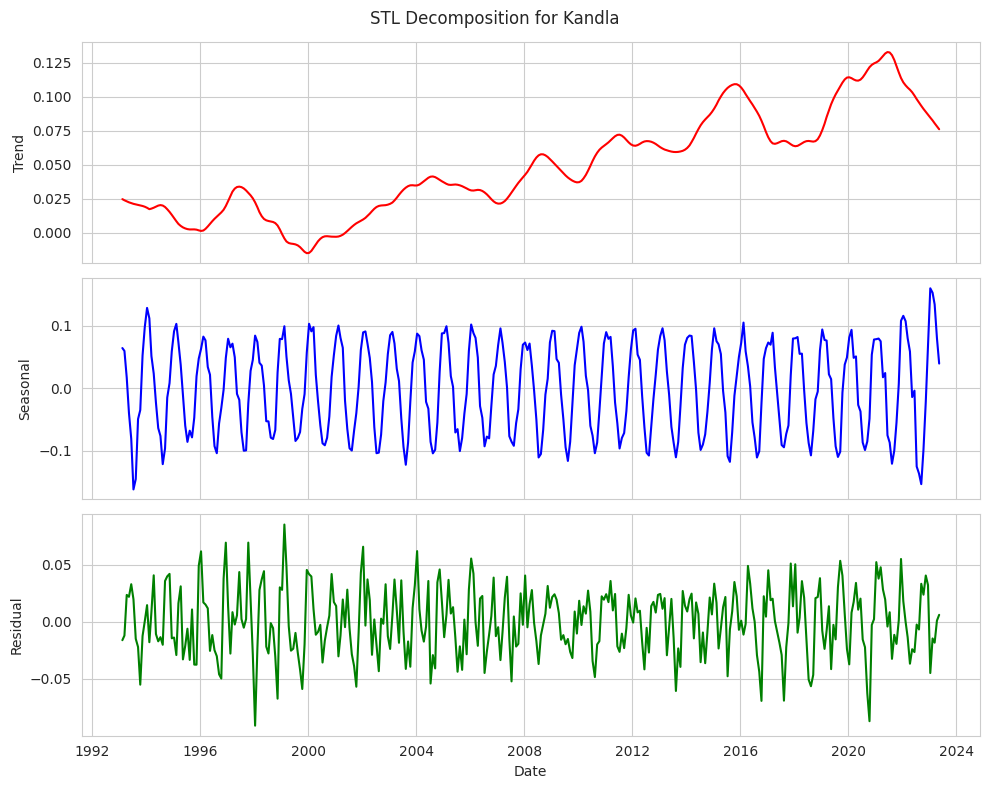

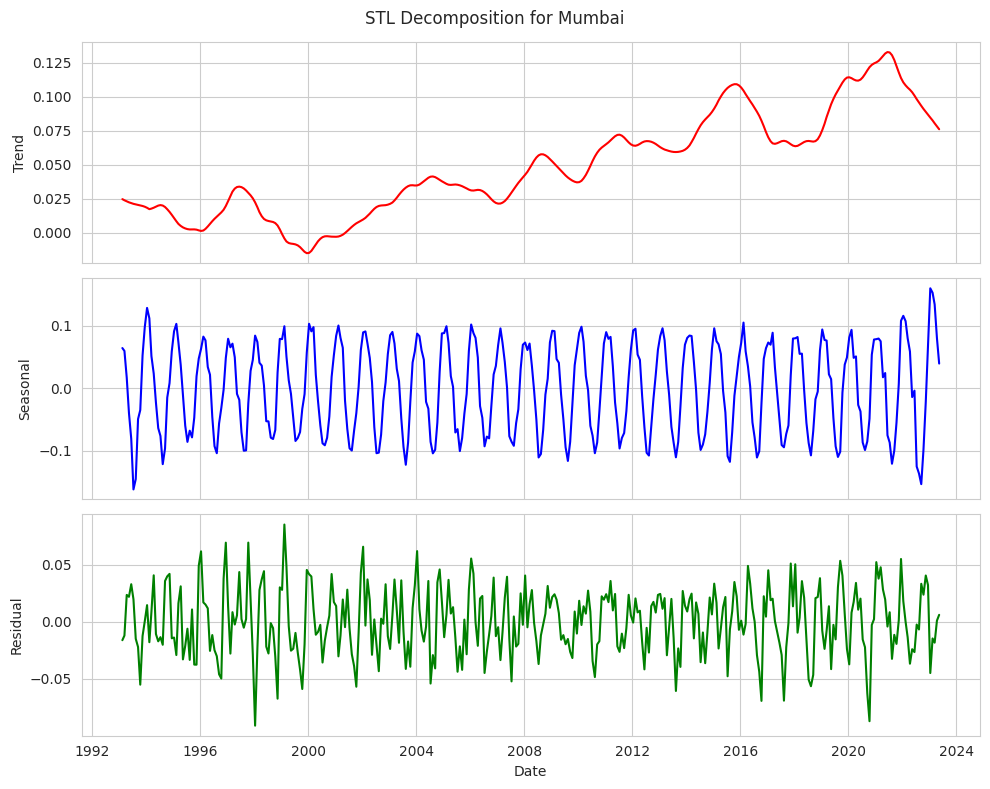

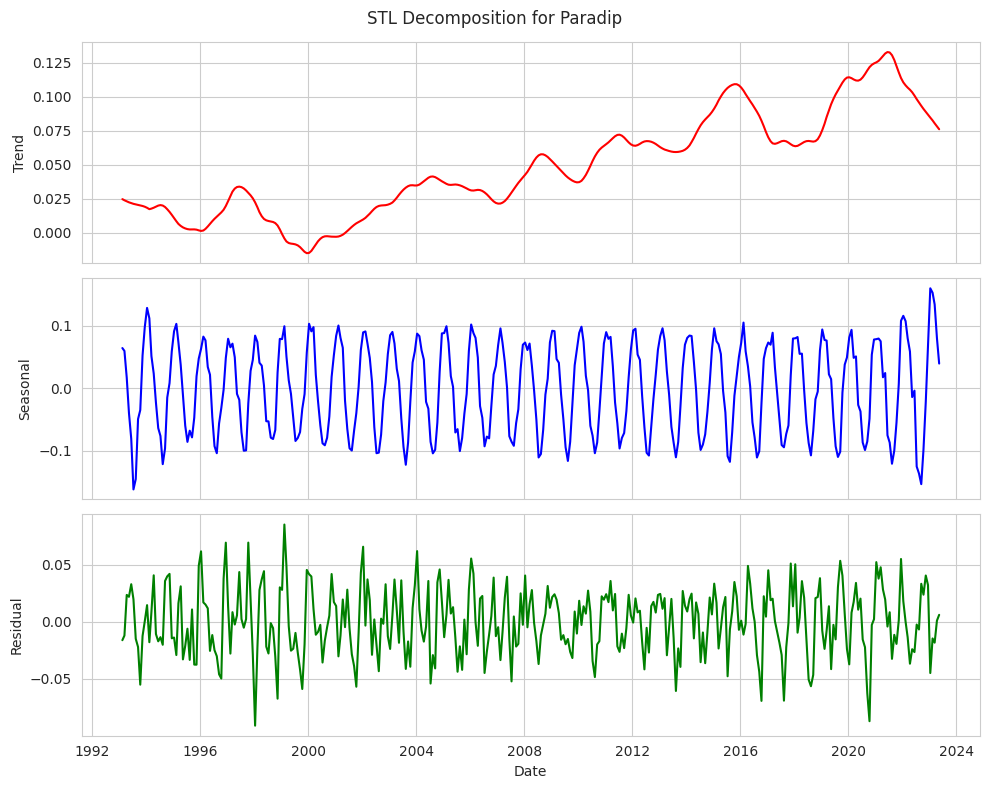

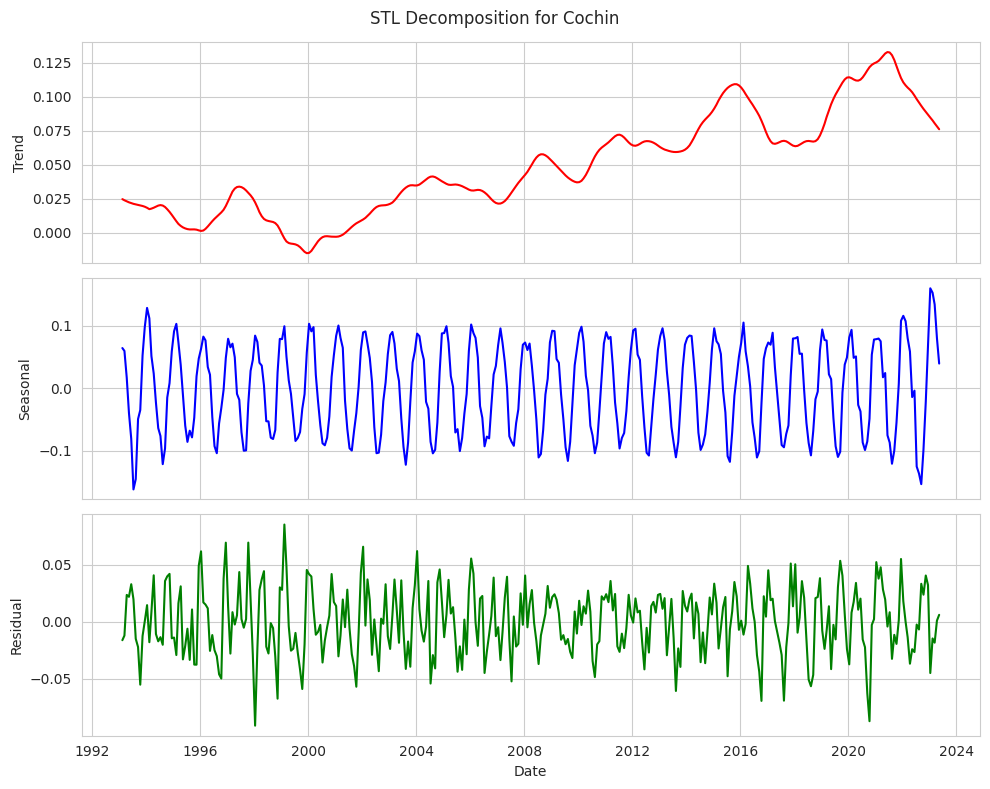

In [ ]:
for port in ['Vishakhapatnam', 'Kandla', 'Mumbai', 'Paradip', 'Cochin']:
    # Plot the decomposition for each port
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
    fig.suptitle(f'STL Decomposition for {port}')

    # Plot trend component
    ax1.plot(data.index, result.trend, color='red')
    ax1.set_ylabel('Trend')

    # Plot seasonal component
    ax2.plot(data.index, result.seasonal, color='blue')
    ax2.set_ylabel('Seasonal')

    # Plot residual component
    ax3.plot(data.index, result.resid, color='green')
    ax3.set_ylabel('Residual')
    ax3.set_xlabel('Date')

    plt.tight_layout()
    plt.show()

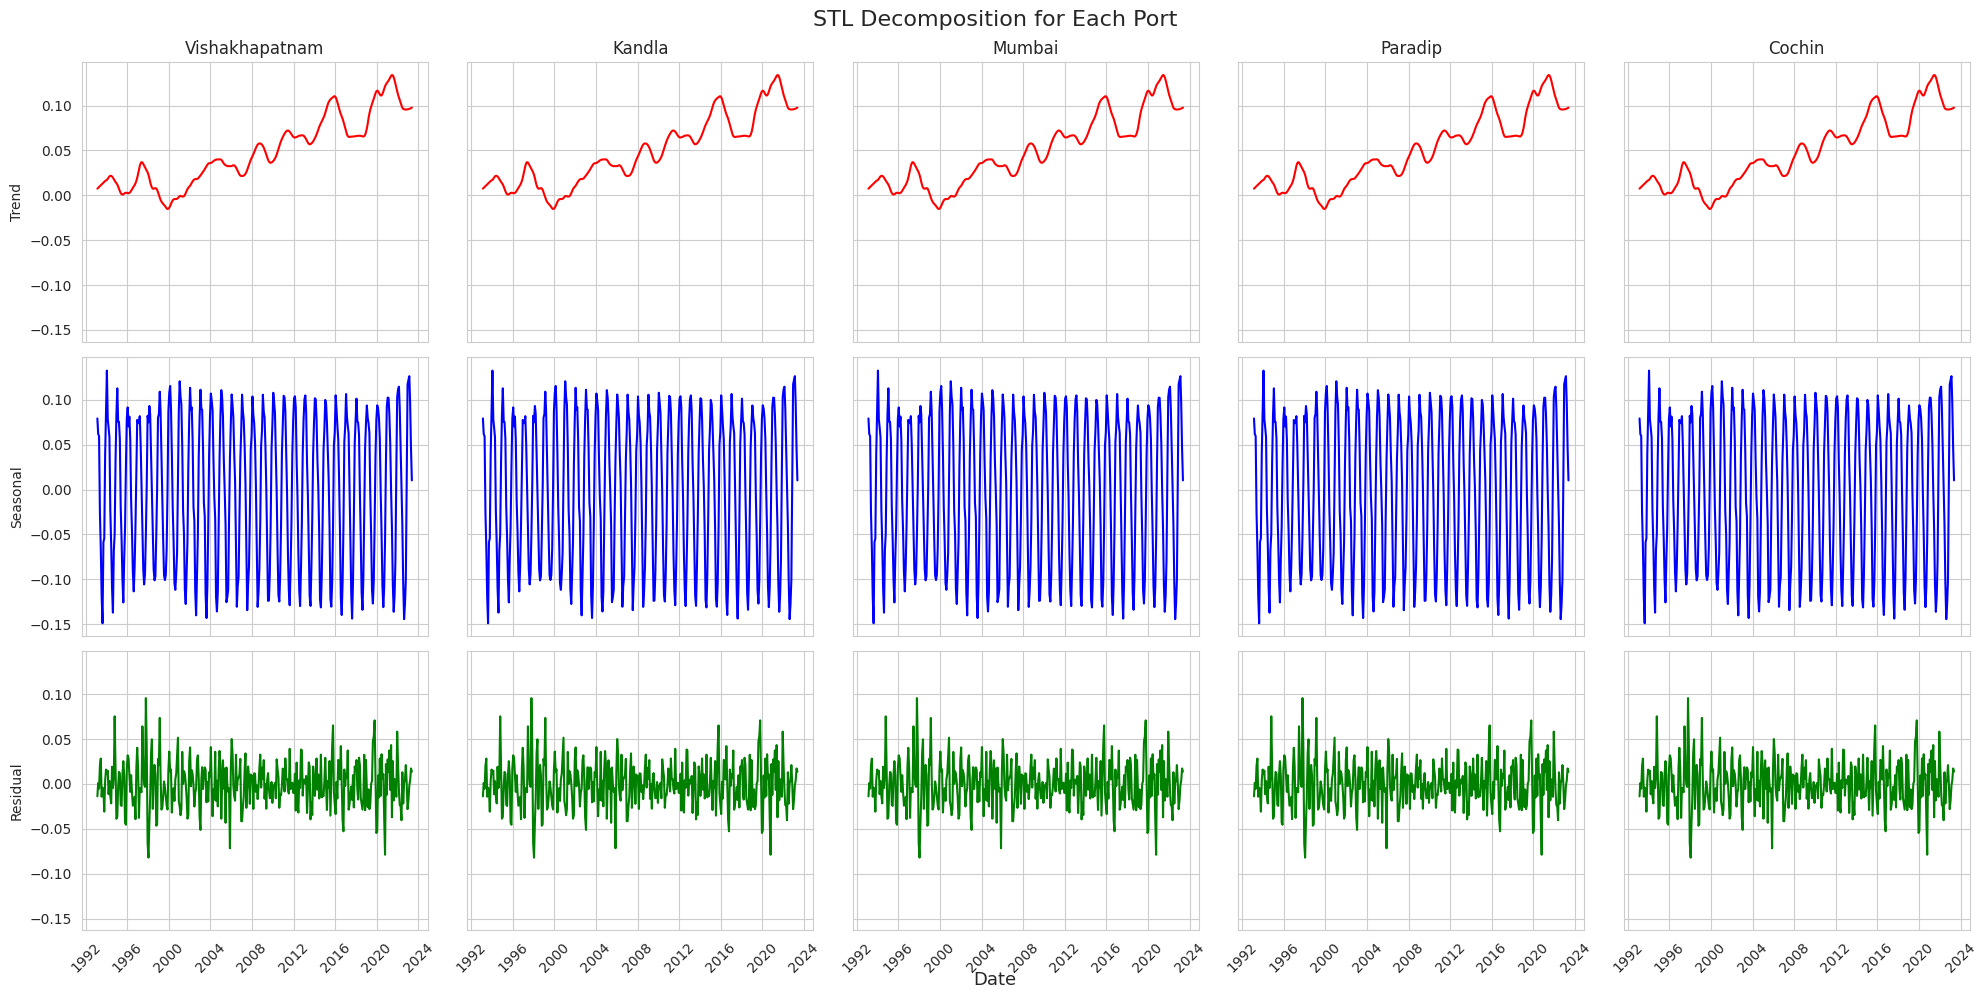

In [ ]:
# Create a figure for all ports
fig, axs = plt.subplots(3, 5, figsize=(20, 10), sharex=True, sharey=True)
fig.suptitle('STL Decomposition for Each Port', fontsize=16)

# Perform STL decomposition for each port
for i, port in enumerate(['Vishakhapatnam', 'Kandla', 'Mumbai', 'Paradip', 'Cochin']):
    # Plot trend component
    axs[0, i].plot(data.index, result.trend, color='red')
    axs[0, i].set_title(port)
    axs[0, 0].set_ylabel('Trend')

    # Plot seasonal component
    axs[1, i].plot(data.index, result.seasonal, color='blue')
    axs[1, 0].set_ylabel('Seasonal')

    # Plot residual component
    axs[2, i].plot(data.index, result.resid, color='green')
    axs[2, 0].set_ylabel('Residual')

# Set a single x-axis label for the entire figure
fig.text(0.5, 0.01, 'Date', ha='center', va='center', fontsize=13)

# Rotate x-axis labels for all subplots
for ax in axs.flat:
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

**Observations and Interpretation**

**Trend Component (Top Row):**

* **Upward Trend:** All ports show a general upward trend in SLA over time, indicating a gradual rise in sea levels since 1993. This aligns with the results from the linear trend analysis, suggesting an overall increase in mean sea level in these regions.
* **Variation Among Ports:** Although all ports show an increasing trend, the rate and shape of the trend vary slightly among them. Ports like Mumbai and Kandla seem to have a more pronounced upward trend compared to Visakhapatnam and Paradip.
* **Recent Increase:** For most ports, especially Mumbai and Cochin, the trend appears to rise more steeply in recent years, suggesting an acceleration in sea level rise.

**Seasonal Component (Middle Row):**

* **Consistent Seasonal Patterns:** All ports exhibit strong, regular seasonal patterns in SLA, characterized by peaks and troughs within each year. This likely reflects cyclical changes in sea level due to monsoon patterns, tides, and other seasonal factors.
* **Amplitude Differences:** While the seasonal pattern is generally consistent across ports, the amplitude (height of peaks and troughs) varies. Ports like Mumbai and Kandla show slightly higher seasonal variation compared to others, which might be due to regional climatic or oceanographic factors.
* **Stable Seasonality:** The seasonal component remains relatively stable over time, indicating that these seasonal fluctuations are predictable and have not changed significantly over the study period.

**Residual Component (Bottom Row):**

* **Random Noise:** The residuals appear to fluctuate around zero with no clear pattern, representing the irregular variations in SLA that are not explained by the trend or seasonal components.
* **Higher Variability in Early Years:** Some ports, such as Paradip and Visakhapatnam, show slightly higher residual variability in the early years of the dataset (around the 1990s), possibly due to less accurate data or regional anomalies in those years.
* **Stable Residuals:** In recent years, residuals are more consistent and centered around zero for all ports, suggesting a good model fit of the trend and seasonal components.

**Summary**

The STL decomposition shows a clear upward trend in sea levels across all ports, along with a strong seasonal pattern and minimal unexplained variability. This suggests that both the trend (indicative of rising sea levels) and seasonality (likely driven by monsoonal and tidal cycles) are well-defined components of SLA for these regions. The residual component indicates that the model captures most of the SLA variability, leaving little unexplained.

This decomposition provides insights for predictive modeling, where the trend and seasonal components can inform models aiming to forecast future SLA values for these ports.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data.to_csv('/content/drive/MyDrive/sla_ports_data.csv', index=True)